In [1]:
# Reddit data analysis task starter.
import html
import json
import string
import re
import nltk
import praw
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import *
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob

In [2]:
# First collect the data in json-file (follow reddit_collect_data.ipynb); specify file name here
fjson = 'raw_post_comment_data.json'

In [3]:
# read json file with collected posts and comments
# https://docs.python.org/3/tutorial/inputoutput.html#reading-and-writing-files
with open(fjson) as file:
    data = json.load(file)
len(data)

50

In [4]:
# data record example
data[0]

{'id': 'wcl861',
 'title': '[MOD] The Daily Question Thread',
 'text': ' \n\nWelcome to the daily [/r/Coffee](https://www.reddit.com/r/Coffee) question thread!\n\nThere are no stupid questions here, ask a question and get an answer! We all have to start somewhere and sometimes it is hard to figure out just what you are doing right or doing wrong. Luckily, the [/r/Coffee](https://www.reddit.com/r/Coffee) community loves to help out.\n\nDo you have a question about how to use a specific piece of gear or what gear you should be buying? Want to know how much coffee you should use or how you should grind it? Not sure about how much water you should use or how hot it should be? Wondering about your coffee\'s shelf life?\n\nDon\'t forget to use the resources in our [wiki](http://www.reddit.com/r/Coffee/wiki)! We have some great starter guides on our [wiki "Guides" page](https://www.reddit.com/r/Coffee/wiki/guides) and [here is the wiki "Gear By Price" page](http://www.reddit.com/r/Coffee/wiki

In [5]:
# create pandas dataframe from post titles
# https://stackoverflow.com/a/43175477
df_posts = pd.DataFrame([p['title'] for p in data], columns=['title'])
df_posts

,title
0,[MOD] The Daily Question Thread
1,[MOD] What have you been brewing this week?/ C...
2,A whole new experience
3,Simple options for visitors that don't want to...
4,What are your thoughts on kalita wave vs hario...
5,Coffee product recall in US
6,brewing coffee with other liquids?
7,Preinfusion in aeropress
8,(Do) I need an intervention(?)
9,where's that coffee post?


In [6]:
# add columns from other data fields: combine comment and sub-comment text
df_posts['post_id'] = [p['id'] for p in data]
df_posts['text'] = [p['text'] for p in data]
df_posts['comments_lev1'] = [' '.join(p['comments_lev1']) for p in data]
df_posts['comments_lev2'] = [' '.join(p['comments_lev2']) for p in data]
df_posts

,title,post_id,text,comments_lev1,comments_lev2
0,[MOD] The Daily Question Thread,wcl861,\n\nWelcome to the daily [/r/Coffee](https://...,I've recently got a Sage (Breville) Precision ...,I have the same brewer and have always wondere...
1,[MOD] What have you been brewing this week?/ C...,wb5r31,Hey everyone!\n\nWelcome back to the weekly /r...,Three new coffees I've really been looking for...,Pepe is hitting it out of the park with these ...
2,A whole new experience,wc8fzh,I've been drinking grocery store brand bulk pr...,Welcome to the rabbit hole Aeropress would be ...,Was finally introduced to good coffee 8 months...
3,Simple options for visitors that don't want to...,wcs0b9,We're starting to get more company in our new ...,I use my drip brewer (breville precision) for ...,I like the idea of pre-grinding.... Better tha...
4,What are your thoughts on kalita wave vs hario...,wcu85l,,"They are BOTH worth owning, but if I could onl...",Yeah I’ve heard the kalita is more suitable fo...
5,Coffee product recall in US,wcaxbw,"Oatley, Stumptown/Intelligentsia carton drinks...",I drank the Oatly…. Oops.. Whew... I buy the 6...,
6,brewing coffee with other liquids?,wcw9rl,I'm not new to making coffee but I was wonderi...,"Booze, the ethanol will be doing the organic e...",Lol Yeah was gonna use aeropress but I won't d...
7,Preinfusion in aeropress,wcv14o,"Sup guys, I’ve been using almost daily my aero...","First of all, and correct me if I'm wrong, are...",This is good advice. I used to do the blooming...
8,(Do) I need an intervention(?),wcuwo7,I don't know how your consume and brewing is g...,"Coffee is good. Still more to try. Stovetop, p...",But only slightly. Seems okay to me. 😂
9,where's that coffee post?,wcuvl1,"Hi, awhile back I read a really funny post thi...",,


In [7]:
# text cleaning function: see prior class modules
stop_words = nltk.corpus.stopwords.words('english')
new_stop_words = ['hey','everyone','ive','subreddit','every','day','getting','new','unionizing','peeps',
                  'asking','begin','horror','op','stories','telling','unionize','im','organizer','one',
                  'broad','newer','filed','want','share','broad','strokes','got','whole','idea','seemed',
                  'nebulous','scary','first','board','actually','suprisingly','easy','start','hope',
                  'sharing','experience','make','think','less','intimidating','may','whether','right','post',
                  'isnt','really','conversation','figure','step','reach','seriously','even','thinking',
                  'wanting','theyre','twitter','sbworkersunited','advice','stage','likely','theres','thats',
                  'already','organizing','put','contact','spoken','four','past','couple','RIP','cats','tiktok',
                  'why','meme','bojack','dumping','fuck','advice','gon','na','kno','cuz','trenta','rant',
                  'sensitive','documentation','pregnancy','honest','mistake','shit','love','u','time','know',
                  'partner','get','much','someone','need','thing','lol','still','looks','like','union','dues',
                  'dress','code','end','keg','pronoun','pins','mental','health','us','sm','charge','wear',
                  'shoes','go','home','never','ball','coffee', 'use','cup','water']

stop_words.extend(new_stop_words)

# strictly speaking, this is a closure: uses a wider-scope variable stop_words
# (disregard this note if you are a Python beginner)
def text_cleanup(s):
    s_unesc = html.unescape(re.sub(r"http\S+", "", re.sub('\n+', ' ', s)))
    s_noemoji = s_unesc.encode('ascii', 'ignore').decode('ascii')
    # normalize to lowercase and tokenize
    wt = word_tokenize(s_noemoji.lower())
    
    # filter word-tokens
    wt_filt = [w for w in wt if (w not in stop_words) and (w not in string.punctuation) and (w.isalnum())]
    
    # return clean string
    return ' '.join(wt_filt)

In [8]:
# add clean text column with combined comments of both levels
# NOTE: apply in pandas applies a function to each element of the selected column
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
df_posts['text_clean'] = (df_posts['text'] + df_posts['comments_lev1'] + df_posts['comments_lev2']).apply(text_cleanup)
df_posts

,title,post_id,text,comments_lev1,comments_lev2,text_clean
0,[MOD] The Daily Question Thread,wcl861,\n\nWelcome to the daily [/r/Coffee](https://...,I've recently got a Sage (Breville) Precision ...,I have the same brewer and have always wondere...,welcome daily question thread stupid questions...
1,[MOD] What have you been brewing this week?/ C...,wb5r31,Hey everyone!\n\nWelcome back to the weekly /r...,Three new coffees I've really been looking for...,Pepe is hitting it out of the park with these ...,welcome back weekly thread brewing ask bean re...
2,A whole new experience,wc8fzh,I've been drinking grocery store brand bulk pr...,Welcome to the rabbit hole Aeropress would be ...,Was finally introduced to good coffee 8 months...,drinking grocery store brand bulk pre ground 4...
3,Simple options for visitors that don't want to...,wcs0b9,We're starting to get more company in our new ...,I use my drip brewer (breville precision) for ...,I like the idea of pre-grinding.... Better tha...,starting company unlike last house decent shop...
4,What are your thoughts on kalita wave vs hario...,wcu85l,,"They are BOTH worth owning, but if I could onl...",Yeah I’ve heard the kalita is more suitable fo...,worth owning could pick would kalita v60 trick...
5,Coffee product recall in US,wcaxbw,"Oatley, Stumptown/Intelligentsia carton drinks...",I drank the Oatly…. Oops.. Whew... I buy the 6...,,oatley carton drinks affected among others lyo...
6,brewing coffee with other liquids?,wcw9rl,I'm not new to making coffee but I was wonderi...,"Booze, the ethanol will be doing the organic e...",Lol Yeah was gonna use aeropress but I won't d...,making wondering components minerals determine...
7,Preinfusion in aeropress,wcv14o,"Sup guys, I’ve been using almost daily my aero...","First of all, and correct me if I'm wrong, are...",This is good advice. I used to do the blooming...,sup guys using almost daily aeropress last 2y ...
8,(Do) I need an intervention(?),wcuwo7,I don't know how your consume and brewing is g...,"Coffee is good. Still more to try. Stovetop, p...",But only slightly. Seems okay to me. 😂,consume brewing going made today 6 portions si...
9,where's that coffee post?,wcuvl1,"Hi, awhile back I read a really funny post thi...",,,hi awhile back read funny guy wrote detests dr...


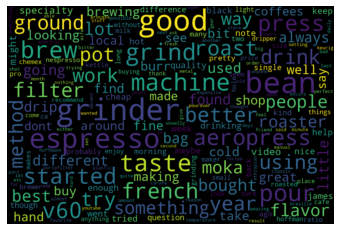

In [9]:
# most common keywords
# https://amueller.github.io/word_cloud/auto_examples/single_word.html#sphx-glr-auto-examples-single-word-py
# https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud
text_combined = ' '.join(df_posts['text_clean'])
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=False).generate(text_combined)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [10]:
# extract keyword counts
# https://stackoverflow.com/questions/60234036/python-word-count-from-wordcloud
kwords = WordCloud().process_text(text_combined)
kwords

{'welcome': 5,
 'daily': 15,
 'question': 6,
 'thread': 2,
 'ask': 15,
 'answer': 2,
 'sometimes': 4,
 'hard': 15,
 'wrong': 9,
 'help': 38,
 'specific': 6,
 'buying': 24,
 'grind': 104,
 'sure': 36,
 'hot': 43,
 'wondering': 5,
 'life': 13,
 'great': 57,
 'price': 25,
 'see': 50,
 'recommend': 22,
 'always': 62,
 'nice': 42,
 'recently': 17,
 'sage': 3,
 'breville': 13,
 'brewer': 36,
 'happy': 21,
 'making': 64,
 'far': 28,
 'noticed': 9,
 'standard': 17,
 'gold': 5,
 'setting': 26,
 'goes': 9,
 'bloom': 12,
 'phase': 2,
 '600ml': 3,
 'straight': 8,
 'heating': 4,
 'brewing': 61,
 'reason': 28,
 'might': 54,
 'fault': 4,
 'world': 20,
 'customise': 1,
 'curious': 15,
 'recommended': 15,
 'found': 73,
 'la': 4,
 'pavoni': 1,
 'junior': 1,
 'grinder': 166,
 'worth': 24,
 'espresso': 155,
 'unfortunately': 4,
 'cant': 10,
 'discourse': 1,
 'around': 56,
 'anywhere': 6,
 'internet': 9,
 'seller': 2,
 'saying': 6,
 'comparable': 3,
 'rancilio': 2,
 'rocky': 1,
 'true': 6,
 'budget': 22,
 

In [11]:
# transform that dictionary into a pandas DataFrame
df_kwords = pd.DataFrame(list(kwords.items()), columns=['keyword', 'count']).set_index('keyword')
df_kwords

,count
keyword,
welcome,5
daily,15
question,6
thread,2
ask,15
...,...
burr carrier,3
reverse osmosis,3
osmosis distilled,2


In [12]:
# transform that dictionary into a pandas DataFrame
df_kwords2 = pd.DataFrame(list(kwords.items()), columns=['keyword', 'count'])
df_kwords2

,keyword,count
0,welcome,5
1,daily,15
2,question,6
3,thread,2
4,ask,15
...,...,...
5078,burr carrier,3
5079,reverse osmosis,3
5080,osmosis distilled,2
5081,educational material,2


In [13]:
df_kwords2[df_kwords2['keyword'].isin(['starbucks','lavazza', 'peets', 
                                       'dunkin','dunkin donuts','costa','blue bottle'])]        

,keyword,count
298,costa,1
1700,peets,2
2153,lavazza,7
2604,dunkin,2
4910,blue bottle,3
5012,dunkin donuts,2


<AxesSubplot:xlabel='keyword'>

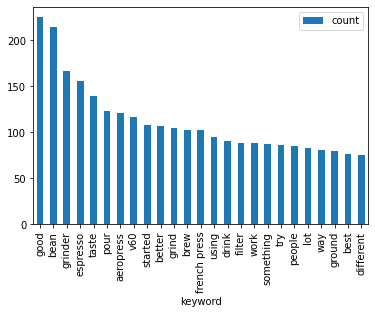

In [14]:
# plot a bar chart with the top keywords
%matplotlib inline
df_kwords.sort_values(by='count', ascending=False).head(25).plot.bar()

In [15]:
# NLTK collocations search (words occuring together): bigrams
# https://www.nltk.org/howto/collocations.html
# http://www.nltk.org/api/nltk.html#nltk.util.bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_finder = BigramCollocationFinder.from_documents([d.split() for d in df_posts['text_clean']])

In [16]:
# filter out bigrams occurring less than three times in the combined text
bigram_finder.apply_freq_filter(3)

In [17]:
# list of bigrams with their frequencies
bigram_freq = list(bigram_finder.ngram_fd.items())
bigram_freq

[(('welcome', 'daily'), 5),
 (('daily', 'question'), 5),
 (('question', 'thread'), 5),
 (('thread', 'stupid'), 5),
 (('stupid', 'questions'), 5),
 (('questions', 'ask'), 5),
 (('ask', 'question'), 5),
 (('question', 'answer'), 5),
 (('answer', 'somewhere'), 5),
 (('somewhere', 'sometimes'), 5),
 (('sometimes', 'hard'), 5),
 (('hard', 'wrong'), 5),
 (('wrong', 'luckily'), 5),
 (('luckily', 'community'), 5),
 (('community', 'loves'), 5),
 (('loves', 'help'), 5),
 (('help', 'question'), 5),
 (('question', 'specific'), 5),
 (('specific', 'piece'), 5),
 (('piece', 'gear'), 5),
 (('gear', 'gear'), 5),
 (('gear', 'buying'), 5),
 (('buying', 'grind'), 5),
 (('grind', 'sure'), 5),
 (('sure', 'hot'), 5),
 (('hot', 'wondering'), 5),
 (('wondering', 'shelf'), 5),
 (('shelf', 'life'), 5),
 (('life', 'forget'), 5),
 (('forget', 'resources'), 5),
 (('resources', 'wiki'), 5),
 (('wiki', 'great'), 5),
 (('great', 'starter'), 5),
 (('starter', 'guides'), 5),
 (('guides', 'wiki'), 5),
 (('wiki', 'guides'

In [18]:
# collect into a pandas dataframe
df_freq = pd.DataFrame([(' '.join(k), v) for k,v in bigram_freq], columns=['keyphrase', 'count'])
df_freq.sort_values(by='count', ascending=False, inplace=True)
df_freq.set_index('keyphrase', inplace = True)
df_freq

,count
keyphrase,
french press,102
moka pot,62
cold brew,41
espresso machine,35
hand grinder,34
...,...
death wish,3
pumpkin spice,3
also tried,3


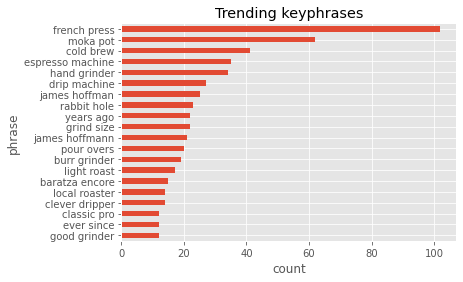

In [19]:
plt.style.use('ggplot')

# render a horizontal bar graph
df_freq.head(20).sort_values(by='count').plot(kind = 'barh')
plt.title('Trending keyphrases')
plt.ylabel('phrase')
plt.xlabel('count')
plt.legend().set_visible(False)
plt.show()

In [20]:
# sentiment analysis
def sentim_polarity(s):
    return TextBlob(s).sentiment.polarity

def sentim_subject(s):
    return TextBlob(s).sentiment.subjectivity

df_posts['polarity'] = df_posts['text_clean'].apply(sentim_polarity)
df_posts['subjectivity'] = df_posts['text_clean'].apply(sentim_subject)
df_posts

,title,post_id,text,comments_lev1,comments_lev2,text_clean,polarity,subjectivity
0,[MOD] The Daily Question Thread,wcl861,\n\nWelcome to the daily [/r/Coffee](https://...,I've recently got a Sage (Breville) Precision ...,I have the same brewer and have always wondere...,welcome daily question thread stupid questions...,0.185119,0.579875
1,[MOD] What have you been brewing this week?/ C...,wb5r31,Hey everyone!\n\nWelcome back to the weekly /r...,Three new coffees I've really been looking for...,Pepe is hitting it out of the park with these ...,welcome back weekly thread brewing ask bean re...,0.210904,0.516095
2,A whole new experience,wc8fzh,I've been drinking grocery store brand bulk pr...,Welcome to the rabbit hole Aeropress would be ...,Was finally introduced to good coffee 8 months...,drinking grocery store brand bulk pre ground 4...,0.201366,0.500733
3,Simple options for visitors that don't want to...,wcs0b9,We're starting to get more company in our new ...,I use my drip brewer (breville precision) for ...,I like the idea of pre-grinding.... Better tha...,starting company unlike last house decent shop...,0.072934,0.517012
4,What are your thoughts on kalita wave vs hario...,wcu85l,,"They are BOTH worth owning, but if I could onl...",Yeah I’ve heard the kalita is more suitable fo...,worth owning could pick would kalita v60 trick...,0.217803,0.534091
5,Coffee product recall in US,wcaxbw,"Oatley, Stumptown/Intelligentsia carton drinks...",I drank the Oatly…. Oops.. Whew... I buy the 6...,,oatley carton drinks affected among others lyo...,0.217857,0.503571
6,brewing coffee with other liquids?,wcw9rl,I'm not new to making coffee but I was wonderi...,"Booze, the ethanol will be doing the organic e...",Lol Yeah was gonna use aeropress but I won't d...,making wondering components minerals determine...,-0.030417,0.431806
7,Preinfusion in aeropress,wcv14o,"Sup guys, I’ve been using almost daily my aero...","First of all, and correct me if I'm wrong, are...",This is good advice. I used to do the blooming...,sup guys using almost daily aeropress last 2y ...,0.127083,0.483264
8,(Do) I need an intervention(?),wcuwo7,I don't know how your consume and brewing is g...,"Coffee is good. Still more to try. Stovetop, p...",But only slightly. Seems okay to me. 😂,consume brewing going made today 6 portions si...,0.012755,0.361735
9,where's that coffee post?,wcuvl1,"Hi, awhile back I read a really funny post thi...",,,hi awhile back read funny guy wrote detests dr...,0.256667,0.573333


In [21]:
# define the list of brands to analyze, consistent with the search topicI 
# for which the subreddits were collected
brands = ['starbucks','lavazza', 'peets', 'dunkin','dunkin donuts','costa','blue bottle'] 

In [22]:
df_brands = pd.DataFrame(brands, columns=['brand'])
df_brands

,brand
0,starbucks
1,lavazza
2,peets
3,dunkin
4,dunkin donuts
5,costa
6,blue bottle


In [23]:
def brand_sentiment(b):
    return df_posts[df_posts['text_clean'].str.contains(b)]['polarity'].mean()

In [24]:
df_brands['average_sentiment'] = df_brands['brand'].apply(brand_sentiment)
df_brands.sort_values(by='average_sentiment', ascending=False)

,brand,average_sentiment
5,costa,0.210904
1,lavazza,0.207882
2,peets,0.184835
0,starbucks,0.163698
6,blue bottle,0.155890
3,dunkin,0.137872
4,dunkin donuts,0.137872


In [25]:
df_posts.sort_values(by='polarity', ascending=False).head(10)

,title,post_id,text,comments_lev1,comments_lev2,text_clean,polarity,subjectivity
13,Specialty shops in Newfoundland?,wcrqbf,Hi all! I will be visiting the beautiful provi...,Upvoted because Newfoundland is one of my favo...,,hi visiting beautiful province newfoundland se...,0.319643,0.535714
39,Kindly explain what is going on in my brewing ...,wbnvvf,"First off, expert coffee drinker but newbie co...",You can use pre-ground coffee in a pressurized...,why is that? Not really. If you use a built-in...,expert drinker newbie maker trying things boug...,0.277755,0.573776
9,where's that coffee post?,wcuvl1,"Hi, awhile back I read a really funny post thi...",,,hi awhile back read funny guy wrote detests dr...,0.256667,0.573333
14,Milk frothing with french press,wcquec,"Hi guys, so I know that this method of obtaini...","Just buy the french press, assuming you have s...",But will frothing milk ruin it in time? I hear...,hi guys method obtaining good milk frothing ca...,0.250000,0.300000
17,How do I graduate from Nespresso?,wbvpya,Hey folks! \n\nA “Nespresso guy” here wanting ...,Get a good grinder and an aeropress. Grinder i...,Agreed. Depending on your budget something lik...,folks nespresso guy branch bit serious beyond ...,0.231798,0.514971
36,Drinking directly from a Press Espro PO,wb8y1d,I've been researching here and other places on...,"I have to say, for your scenario I find it har...",Thanks! I’ll check out the P1 as well. No stra...,researching places web espro airline pilot loo...,0.221449,0.539420
5,Coffee product recall in US,wcaxbw,"Oatley, Stumptown/Intelligentsia carton drinks...",I drank the Oatly…. Oops.. Whew... I buy the 6...,,oatley carton drinks affected among others lyo...,0.217857,0.503571
4,What are your thoughts on kalita wave vs hario...,wcu85l,,"They are BOTH worth owning, but if I could onl...",Yeah I’ve heard the kalita is more suitable fo...,worth owning could pick would kalita v60 trick...,0.217803,0.534091
1,[MOD] What have you been brewing this week?/ C...,wb5r31,Hey everyone!\n\nWelcome back to the weekly /r...,Three new coffees I've really been looking for...,Pepe is hitting it out of the park with these ...,welcome back weekly thread brewing ask bean re...,0.210904,0.516095
25,[MOD] The Daily Question Thread,wbtzgn,\n\nWelcome to the daily [/r/Coffee](https://...,Anyone using electric screwdriver/drill with 1...,The James Hoffmann video from yesterday actual...,welcome daily question thread stupid questions...,0.202714,0.533586


In [26]:
df_posts.sort_values(by='polarity', ascending=True).head(10)

,title,post_id,text,comments_lev1,comments_lev2,text_clean,polarity,subjectivity
20,Oxo Cold Brew replacement metal mesh screen?,wcgeaw,"Long story short, I lost mine. Does anyone kno...",Call them.,,long story short lost mine anyone replacement ...,-0.162500,0.500000
22,Brewista Artisan kettle rattling?,wc4w74,We recently bought a Brewista Artisan temperat...,,,recently bought brewista artisan temperature c...,-0.037500,0.481250
6,brewing coffee with other liquids?,wcw9rl,I'm not new to making coffee but I was wonderi...,"Booze, the ethanol will be doing the organic e...",Lol Yeah was gonna use aeropress but I won't d...,making wondering components minerals determine...,-0.030417,0.431806
34,Day 1 with the Baratza Encore M2 burr upgrade,wb330c,I usually start the grinder while im filling t...,Why not grind just the amount that you need? Y...,im not complaining. im saying i let it run and...,usually grinder filling rinsing carafe things ...,-0.024117,0.459278
41,908g not 1kg,wa8u55,Why do so many coffee packs come in 908g and n...,2 pounds = 907.2g 908g is equal to 37 chicken ...,Because America will do literally anything to ...,many packs come 908g 1 kg baffling luck friend...,-0.021579,0.489677
27,Is it possible to grow coffee in Utah?,wcd7yl,I've done some research and I've looked in thi...,It is possible to *grow* coffee there. \n\nIt ...,My dad was working with a grower in the Santa ...,done research looked see possible grow usa rea...,-0.021014,0.568116
11,Sage Barista Pro - Watery Shots,wclilg,Question for those who've been at this a while...,What do you mean by watery? Do you pull your s...,,question barista pro month morning shots start...,-0.003646,0.560938
12,What do you call equal parts espresso/water in...,wcfgj8,In some cafes in Toronto I could order a long ...,"That's like an Americano, but you're likely go...","Yeah, I was a barista for years and I had thre...",cafes toronto could order long black 5oz appro...,0.002299,0.363506
8,(Do) I need an intervention(?),wcuwo7,I don't know how your consume and brewing is g...,"Coffee is good. Still more to try. Stovetop, p...",But only slightly. Seems okay to me. 😂,consume brewing going made today 6 portions si...,0.012755,0.361735
35,Increasing extraction in pre-ground,wbi33a,I'm a beginner. Since I'm just getting into th...,Do you have a French press lying about. Could ...,I have a French press and am disgracefully car...,beginner since hobby trying gauge kept things ...,0.020076,0.395455


In [27]:
df_posts.sort_values(by='comments_lev1', ascending=False).head(20)

,title,post_id,text,comments_lev1,comments_lev2,text_clean,polarity,subjectivity
38,Just have to crow a bit: my roast turned out A...,wahlox,"Hello, all! I'm sitting here drinking an amazi...",specialty roaster here. \ni find my roasts ope...,Longer strokes for different folks? ;) Any tho...,hello sitting drinking amazing beans roasted y...,0.113409,0.486313
16,Bean recommendations for bright+sweet cold brew,wcofwm,My personal coffee preference is bright with r...,https://swroasting.com/culled-brew.html The de...,,personal preference bright rich sweetness tast...,0.150379,0.748864
43,[MOD] Show off your gear! - Battle-station Cen...,wabbde,Let's see your battle-stations or new purchase...,https://imgur.com/a/mhaao2D\n\nJust moved in t...,,let see purchases tell pictures let daily joe ...,0.089796,0.463265
24,What's this kind of single-cup pour-over coffe...,wbd1ut,"**EDIT**: Effectively ""solved"". What I'm looki...","Your original looks like an ""updated"" version ...","Yeah that might be the closest equivalent, tha...",edit effectively solved looking might called v...,0.198925,0.490049
39,Kindly explain what is going on in my brewing ...,wbnvvf,"First off, expert coffee drinker but newbie co...",You can use pre-ground coffee in a pressurized...,why is that? Not really. If you use a built-in...,expert drinker newbie maker trying things boug...,0.277755,0.573776
28,Ethiopian beans always seem to have a lot of f...,wb951v,I’ve found this with most Ethiopian beans. The...,"Yeah, how does it taste? Ethiopian coffees are...",Aeopress or grind coarser and slower pour. It’...,found ethiopian beans seem smaller denser find...,0.119270,0.528201
34,Day 1 with the Baratza Encore M2 burr upgrade,wb330c,I usually start the grinder while im filling t...,Why not grind just the amount that you need? Y...,im not complaining. im saying i let it run and...,usually grinder filling rinsing carafe things ...,-0.024117,0.459278
11,Sage Barista Pro - Watery Shots,wclilg,Question for those who've been at this a while...,What do you mean by watery? Do you pull your s...,,question barista pro month morning shots start...,-0.003646,0.560938
2,A whole new experience,wc8fzh,I've been drinking grocery store brand bulk pr...,Welcome to the rabbit hole Aeropress would be ...,Was finally introduced to good coffee 8 months...,drinking grocery store brand bulk pre ground 4...,0.201366,0.500733
10,Grinding for Breville Precision Brewer using W...,wcujk6,Hi all! As the title suggests- I have been str...,Use your eyes and grind a bit more coarse than...,,hi title struggling find grind setting wilfa s...,0.175000,0.692778


In [28]:
# combine all text for a specific brand
def brand_all_text(b):
    # https://stackoverflow.com/a/51871650
    return ' '.join(df_posts[df_posts['text_clean'].str.contains(b)]['text_clean'])

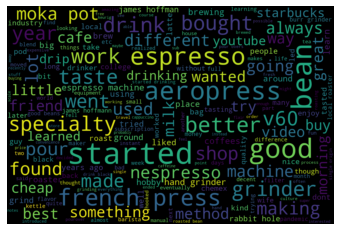

In [29]:
b = 'peets'
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=100).generate(brand_all_text(b))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

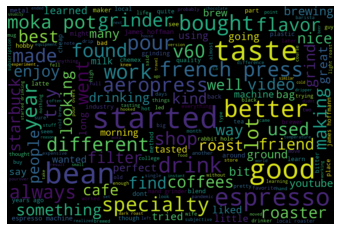

In [30]:
c = 'starbucks'
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=100).generate(brand_all_text(c))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

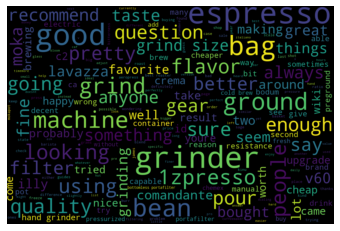

In [31]:
d = 'lavazza'
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=100).generate(brand_all_text(d))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

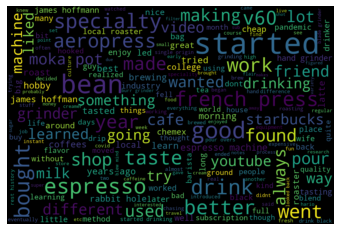

In [32]:
e = 'dunkin'
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=100).generate(brand_all_text(e))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

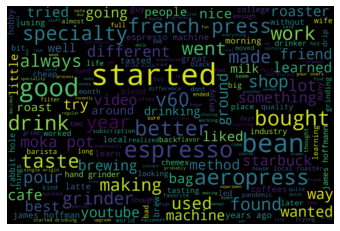

In [33]:
f = 'blue bottle'
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=100).generate(brand_all_text(f))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

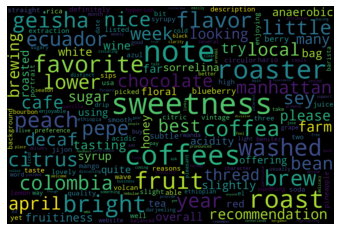

In [34]:
g = 'costa'
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=100).generate(brand_all_text(g))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()